---
title: <h1 style="font-weight:bold; font-family:Arial; color:#00205b;">Understanding How Customers Feel About British Airways Flight Experience</h1>
---


> This project was completed as part of a job simulation as a junior data scientist at British Airways. I found this project very interesting and decided to share it with the community. 
> I hope you find it useful. Please feel free to reach out to me if you have any questions or comments. The source code for this project can be found on my [GitHub](https://github.com/Simontagbor/BritishAirways-data-science) page

<h2> Introduction </h2>
<p>Based on online reviews collected from [Airlinequality.com](https://www.airlinequality.com/airline-reviews/british-airways), I performed topic modeling and sentiment analysis to understand British Airways' customers' flight experiences. The project was done in Python with the following libraries: `requests`, `BeautifulSoup`, `pandas`, `numpy`, `nltk`, `gensim`, `pyLDAvis`, `matplotlib`, `seaborn`, `wordcloud`, `textblob`, `vaderSentiment`, `scikit-learn`, `spacy`, `re`, `warnings`, `pickle`, `time`, `random`, `matplotlib`, `seaborn`, `wordcloud`, `textblob`, `vaderSentiment`, `scikit-learn`, `logging`, `datetime`, `IPython`, `jupyter`, `selenium`, `webdriver`, `time`, `pickle`, `pyLDAvis`, `matplotlib`,
</p>
<h2>Project Overview</h2>
<em>For this project I completed the following tasks:</em>

- [x] Retrieve 1000 online reviews About British Airways from [Airlinequality.com](https://www.airlinequality.com/airline-reviews/british-airways)
- [x] Clean and Preprocess The Data
- [x] Conduct Data exploration and visualization
- [x] Perfom Topic modeling on Reviews
- [x] Perform Sentiment analysis on Reviews




<h2>Task 1 - Data Retrieval</h2>
Using `requests` and `BeautifulSoup` libraries, I collected links to review pages, then collected text data on each review page. Afterward, the review texts were saved to a `.csv` file.


<h3>Scraping Data From Skytrax</h3>

<a href="https://www.airlinequality.com/airline-reviews/british-airways">This link</a> shows all reviews related to British Airways. 

<h4>Importing the libraries</h4>

In [1]:
# package to handle web scraping
import requests
from bs4 import BeautifulSoup
# p
# packages to manipulate data
import pandas as pd
import numpy as np

# packages for sentiment analysis
from textblob import TextBlob

# packages to visualize data
import matplotlib.pyplot as plt
import seaborn as sns
import pyLDAvis
# import wordcloud to create wordclouds
from wordcloud import WordCloud

# packages to build Topic model
import sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# packages to clean text
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer

<h4>Collecting the links to the review pages and retrieving each review</h4>

In [2]:
base_url = "https://www.airlinequality.com/airline-reviews/british-airways"
pages = 10
page_size = 100

reviews = []

# for i in range(1, pages + 1):
for i in range(1, pages + 1):

    print(f"Scraping page {i}")

    # Create URL to collect links from paginated data
    url = f"{base_url}/page/{i}/?sortby=post_date%3ADesc&pagesize={page_size}"

    # Collect HTML data from this page
    response = requests.get(url)

    # Parse content
    content = response.content
    parsed_content = BeautifulSoup(content, 'html.parser')
    for para in parsed_content.find_all("div", {"class": "text_content"}):
        reviews.append(para.get_text())
    
    print(f"   ---> {len(reviews)} total reviews")

Scraping page 1


   ---> 100 total reviews
Scraping page 2
   ---> 200 total reviews
Scraping page 3
   ---> 300 total reviews
Scraping page 4
   ---> 400 total reviews
Scraping page 5
   ---> 500 total reviews
Scraping page 6
   ---> 600 total reviews
Scraping page 7
   ---> 700 total reviews
Scraping page 8
   ---> 800 total reviews
Scraping page 9
   ---> 900 total reviews
Scraping page 10
   ---> 1000 total reviews


The code above collects all the links to the review pages and then retrieves each review. The data is then appended to `reviews` list variable.

<h2>Task 2 - Data Preprocessing</h2>

<h4>Create a Dataframe from the reviews list and save it to a local csv file</h4>


In [3]:
df = pd.DataFrame()
df["reviews"] = reviews
df.head()

,reviews
0,Not Verified | Extremely rude ground service....
1,✅ Trip Verified | My son and I flew to Geneva...
2,✅ Trip Verified | For the price paid (bought ...
3,✅ Trip Verified | Flight left on time and arr...
4,✅ Trip Verified | Very Poor Business class pr...


<h4>Save the DataFrame to a local csv file</h4>


In [4]:
df.to_csv("data/BA_reviews.csv")

finally our raw data is saved to a local csv file. The data will be used for the next task.

<h3> Cleaning The Review Data</h3>

After inspecting the data, I noticed that there were some unnecessary text in each of the rows. For example, "✅ Trip Verified" can be removed from each as it's not relevant to what we want to investigate.

In [6]:
#list unwanted data
unwanted_text = ["✅ Trip Verified ", "❎ Not Verified ","Not Verified ", "|   ", " |  ", "|  ", " | ", "| ", "|"]
# punctuation to remove
punctuation = '!"$%&\'()*+,-./:;<=>?[\\]^_`{|}~•@'
#  create a list of stopwords
# nltk.download('stopwords')
stop_words = nltk.corpus.stopwords.words('english')
# add word rooter
word_rooter = nltk.stem.snowball.PorterStemmer(ignore_stopwords=False).stem

# process the file
def clean_review(review, bigrams=False, save_to_file=False):
    """Cleans a review by removing unwanted text, punctuation, and stopwords"""
    for text in unwanted_text:
        if text in review:
            # remove the unwanted text
            review = review.replace(text, "")
    
    # remove numbers
    review = re.sub('[0-9]+', '', review)
    # remove punctuation
    review = re.sub('[%s]' % re.escape(punctuation), '', review)
    # remove double spaces at beginning of review
    review = review.lstrip()
    
    # make all characters lowercase
    review = review.lower()

    if save_to_file:
        with open("data/cleaned_reviews.csv", "a") as f:
            f.write(review + "\n")
    # tokenize the text and remove stop words
    review_token_list = [word for word in review.split(" ") if word not in stop_words]

    # Apply word rooter
    # review_token_list = [word_rooter(word) for word in review_token_list]

    if bigrams:
        review_token_list = review_token_list + [review_token_list[i] + " " + review_token_list[i+1] for i in range(len(review_token_list)-1)]
    
    # join tokens together
    review = " ".join(review_token_list)
    return review

The `clean_review` function takes in a string and returns a string with the following changes

- Removes the "✅ Trip Verified" text from the string
- Removes the "Not Verified | " text from the string
- Removes the "✅ Verified Review | " text from the string 
- it also removes punctuation and numbers from the string
- it also removes unnecessary spaces from the string
- it removes `stopwords` from the string: stopwords are words that are not relevant to the analysis, such as "the", "a", "an", "and", etc.

<h4>Update the DataFrame with the cleaned reviews</h4>

In [7]:
# Create a new column in the DataFrame with the cleaned text
df["cleaned_reviews"] = df["reviews"].apply(clean_review)
df.head(5)

,reviews,cleaned_reviews
0,Not Verified | Extremely rude ground service....,extremely rude ground service nonrev flying lo...
1,✅ Trip Verified | My son and I flew to Geneva...,son flew geneva last sunday skiing holiday les...
2,✅ Trip Verified | For the price paid (bought ...,price paid bought sale decent experience altho...
3,✅ Trip Verified | Flight left on time and arr...,flight left time arrived half hour earlier sch...
4,✅ Trip Verified | Very Poor Business class pr...,poor business class product ba even close airl...


<h2>Task 3 - Conducting Topic Modelling</h2> 

<p>After cleaning the data, we can conduct topic modelling on the data.</p>
<p>Topic modelling is a technique that allows us to extract the main topics from a corpus of text. In this case, we will extract the main topics from the reviews that we have collected.</p>

<h3>Retrieve Main Topics</h3>
<p> I discovered that there are several ways of conducting topic modelling on text data. For this project, I used the <a href="https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation">Latent Dirichlet Allocation (LDA)</a> algorithm to extract the main topics from the reviews. </p>
<p>Latent Dirichlet Allocation(LDA) is based on two general assumptions:</p>
<ol>
    <li>Documents that have similar words usually have the same topic.</li>
    <li>Documents that have groups of words frequently occurring together usually have the same topic.</li>
</ol>

<p>A `document` in LDA means a review in our case</p>
<p> A `topic` in LDA means the main topic of a review, for example, a review can be about the food, the seats, the staff, etc.</p>

The LDA algorithm will extract the main topics from the reviews and assign each review to a topic. The topics will be saved to a `.csv` file for further analysis.

<h4>Vectorize The Reviews</h4>
<p>Before we can use the LDA algorithm, we need to vectorize the reviews. Vectorization is the process of converting text data to numerical data. The LDA algorithm can only work with numerical data.</p>

<p>For example, the review `"The food was great"` will be converted to a vector of numbers such as `[0, 0, 0, 1, 0, 0, 0, 0, 0, 0] `. </p>
<p>The vector has 10 elements, each element represents a word in the review. The number 1 in the vector represents the word "food" in the review. The number 0 represents the other words in the review.</p>

In [8]:

# create the transform and fit it on the cleaned reviews
vectorizer = CountVectorizer(ngram_range=(1, 2), stop_words='english')
tf = vectorizer.fit_transform(df['cleaned_reviews']).toarray()
# get the feature names
tf_feature_names = vectorizer.get_feature_names_out()

# create document term matrix
df_dtm = pd.DataFrame(tf, columns=tf_feature_names)
term_frequency = df_dtm.sum(axis=0).tolist()
doc_lenghts = df_dtm.sum(axis=1).tolist()

The `vectorizer` will be used to create a document-term matrix from the reviews. The document-term matrix is a mathematical matrix that describes the frequency of terms that occur in a collection of documents. In this case, the document-term matrix will be a matrix of the frequency of words that occur in the reviews.

The `tf` variable is a matrix of the frequency of words that occur in the reviews. The `tf_feature_names` variable is a list of the words that occur in the reviews.

The `term_frequency` Variable is a list of the top 20 words that occur in the reviews. The `term_frequency` variable is a list of the top 20 words that occur in the reviews.

The `doc_length` variable is a list of the length of each review. The `doc_length` variable is a list of the length of each review.

<h3>Create LDA model object</h3>

The `lda_model` variable is an object that contains the LDA model. This object will be used to extract the main topics from the reviews.

In [9]:
number_of_topics = 10
try:
    # create the model
    lda_model = LatentDirichletAllocation(n_components=number_of_topics, random_state=0)
    # fit the model on the term frequency matrix
    lda_model.fit(tf)
    print("Model created Succesfully")
except Exception as e:
    print("An error occurred: ", e)

Model created Succesfully


<h3>Visualising the Topics</h3>
<p>To visualize the topics, I used the `pyLDAvis` library. The visualization below shows the topics and the most relevant words in each topic. The size of the bubbles represents the importance of the topics relative to each other. The closer the bubbles are to each other, the more similar the topics are.</p>

<h4>Top five(5) topics from 1000 reviews</h4>

In [10]:
# Create table to display topics
def display_topics(model, feature_names, no_top_words):
    """records the top words in each topic"""
    topic_dict = {}
    for topic_idx, topic in enumerate(model.components_):
        topic_dict["Topic %d words" % (topic_idx)] = ['{}'.format(feature_names[i])
                        for i in topic.argsort()[:-no_top_words - 1:-1]]
        topic_dict["Topic %d weights" % (topic_idx)] = ['{:.1f}'.format(topic[i])
                        for i in topic.argsort()[:-no_top_words - 1:-1]]
    return pd.DataFrame(topic_dict)

df_topic_words = display_topics(lda_model, tf_feature_names, 10)
df_topic_words.head(5)

,Topic 0 words,Topic 0 weights,Topic 1 words,Topic 1 weights,Topic 2 words,Topic 2 weights,Topic 3 words,Topic 3 weights,Topic 4 words,Topic 4 weights,Topic 5 words,Topic 5 weights,Topic 6 words,Topic 6 weights,Topic 7 words,Topic 7 weights,Topic 8 words,Topic 8 weights,Topic 9 words,Topic 9 weights
0,ba,68.4,flight,468.1,flight,121.2,flight,200.3,flight,320.9,ba,64.1,flight,182.6,flight,244.6,ba,145.4,flight,103.3
1,flight,58.0,ba,191.2,ba,84.0,ba,117.2,ba,141.0,flight,60.5,ba,103.1,ba,194.6,flight,142.3,ba,96.0
2,staff,38.7,service,143.1,service,48.6,british,71.6,service,122.1,business,38.9,service,90.5,service,85.8,class,74.5,service,64.7
3,luggage,32.3,time,110.2,time,42.8,airways,69.2,good,95.6,service,35.1,seat,78.4,time,80.7,food,67.2,airways,47.9
4,london,27.1,good,104.8,british,37.0,london,68.3,food,83.4,class,34.1,seats,66.5,told,71.4,business,59.8,british,46.9


<h3>Show Topic Distribution </h3>

To show the top topic distributions for all the reviews, I used `PyLDAvis` to create an interactive visualization of the topics. The visualization below shows the topics and the most relevant words in each topic. The size of the bubbles represents the importance of the topics relative to each other. The closer the bubbles are to each other, the more similar the topics are.

In [11]:
# compute  document  topic distribution
import warnings

# Ignore all warnings
warnings.filterwarnings('ignore')
topic_distribution = lda_model.transform(df_dtm)
panel = pyLDAvis.prepare(lda_model.components_, topic_distribution, doc_lenghts, tf_feature_names, term_frequency, mds='tsne')
pyLDAvis.display(panel)

<p>The distribution shown above highlights the following:</p>
<ul>
    <li>Topic 1: People talked a lot about British Airways' flights</li>
    <li>Topic 2: People also talked a lot about london flights and services</li>
    <li>Topic 3: People also talked about the food and drinks served on the flights</li>
    <li>Topic 4: people also talked a lot about flight crew and services</li>

<h2> Task - 3 Conduct Sentiment Analysis on the Reviews Data</h2>

To Gauge the sentiment of the reviews, I used the `textblob` and `vaderSentiment` libraries. The `textblob` library is a Python library for processing textual data. It provides a simple API for diving into common natural language processing (NLP) tasks such as part-of-speech tagging, noun phrase extraction, sentiment analysis, classification, translation, and more.

<h3>Prepare a cleaned data for analysis</h3>

I called the `clean_review` function on each row of the dataframe and save the cleaned data to a csv file

The `clean_review` function is called with the save_to_file parameter set to True. This will save the cleaned data to a csv file for later use.

In [12]:
df["cleaned_reviews"] = df["reviews"].apply(lambda x: clean_review(x, save_to_file=True))

<h3>Define a function to conduct sentiment analysis on the reviews</h3>

<p>for this analysis I used the `TextBlob` package to conduct sentiment analysis on the reviews. The `TextBlob`  Python library  provides a simple API for diving into common natural language processing (NLP) tasks such as part-of-speech tagging, noun phrase extraction, sentiment analysis, classification and translation.</p>

In [13]:
# import textblob for sentiment analysis
from textblob import TextBlob
def analyse_sentiment():
    """This function returns the sentiment of a review"""
    try:
        # check if cleaned_review  file exists
        with open("data/cleaned_reviews.csv", "r") as f:
            # process the file
            reviews = [line for line in f.readlines() if line.strip()]
            # get sentiment
            sentiments = [TextBlob(review).sentiment.polarity for review in reviews]
            sentiment_scores = ["positive" if sentiment > 0 else 
                                "neutral" if sentiment == 0 else 
                                "negative" for sentiment in sentiments]
            # add sentiment to dataframe
            df["sentiment_score"] = sentiment_scores
        print("Sentiment analysis completed successfully")
    except FileNotFoundError:
        # create the file
        print("cleaned_review.csv not found: Creating file\n", "Please wait...")
        df["cleaned_reviews"] = df["reviews"].apply(lambda x: clean_review(x, save_to_file=True))
        print("File created successfully\n", "resuming sentiment analysis...")
        # restart the function
        analyse_sentiment()
    except Exception as e:
        print("An error occurred: ", e)

<h3>Conduct Analysis</h3>

In [14]:
#  call  the function
analyse_sentiment()
df.head(20)
df.to_csv("data/BA_sentiment_reviews.csv")

Sentiment analysis completed successfully


<h3>Visualise the sentiment of the reviews using pie chart</h3>

I used the `matplotlib` package to render a pie chart visualisation of  the sentiment of the reviews. The pie chart shows the percentage of positive, negative and neutral reviews.

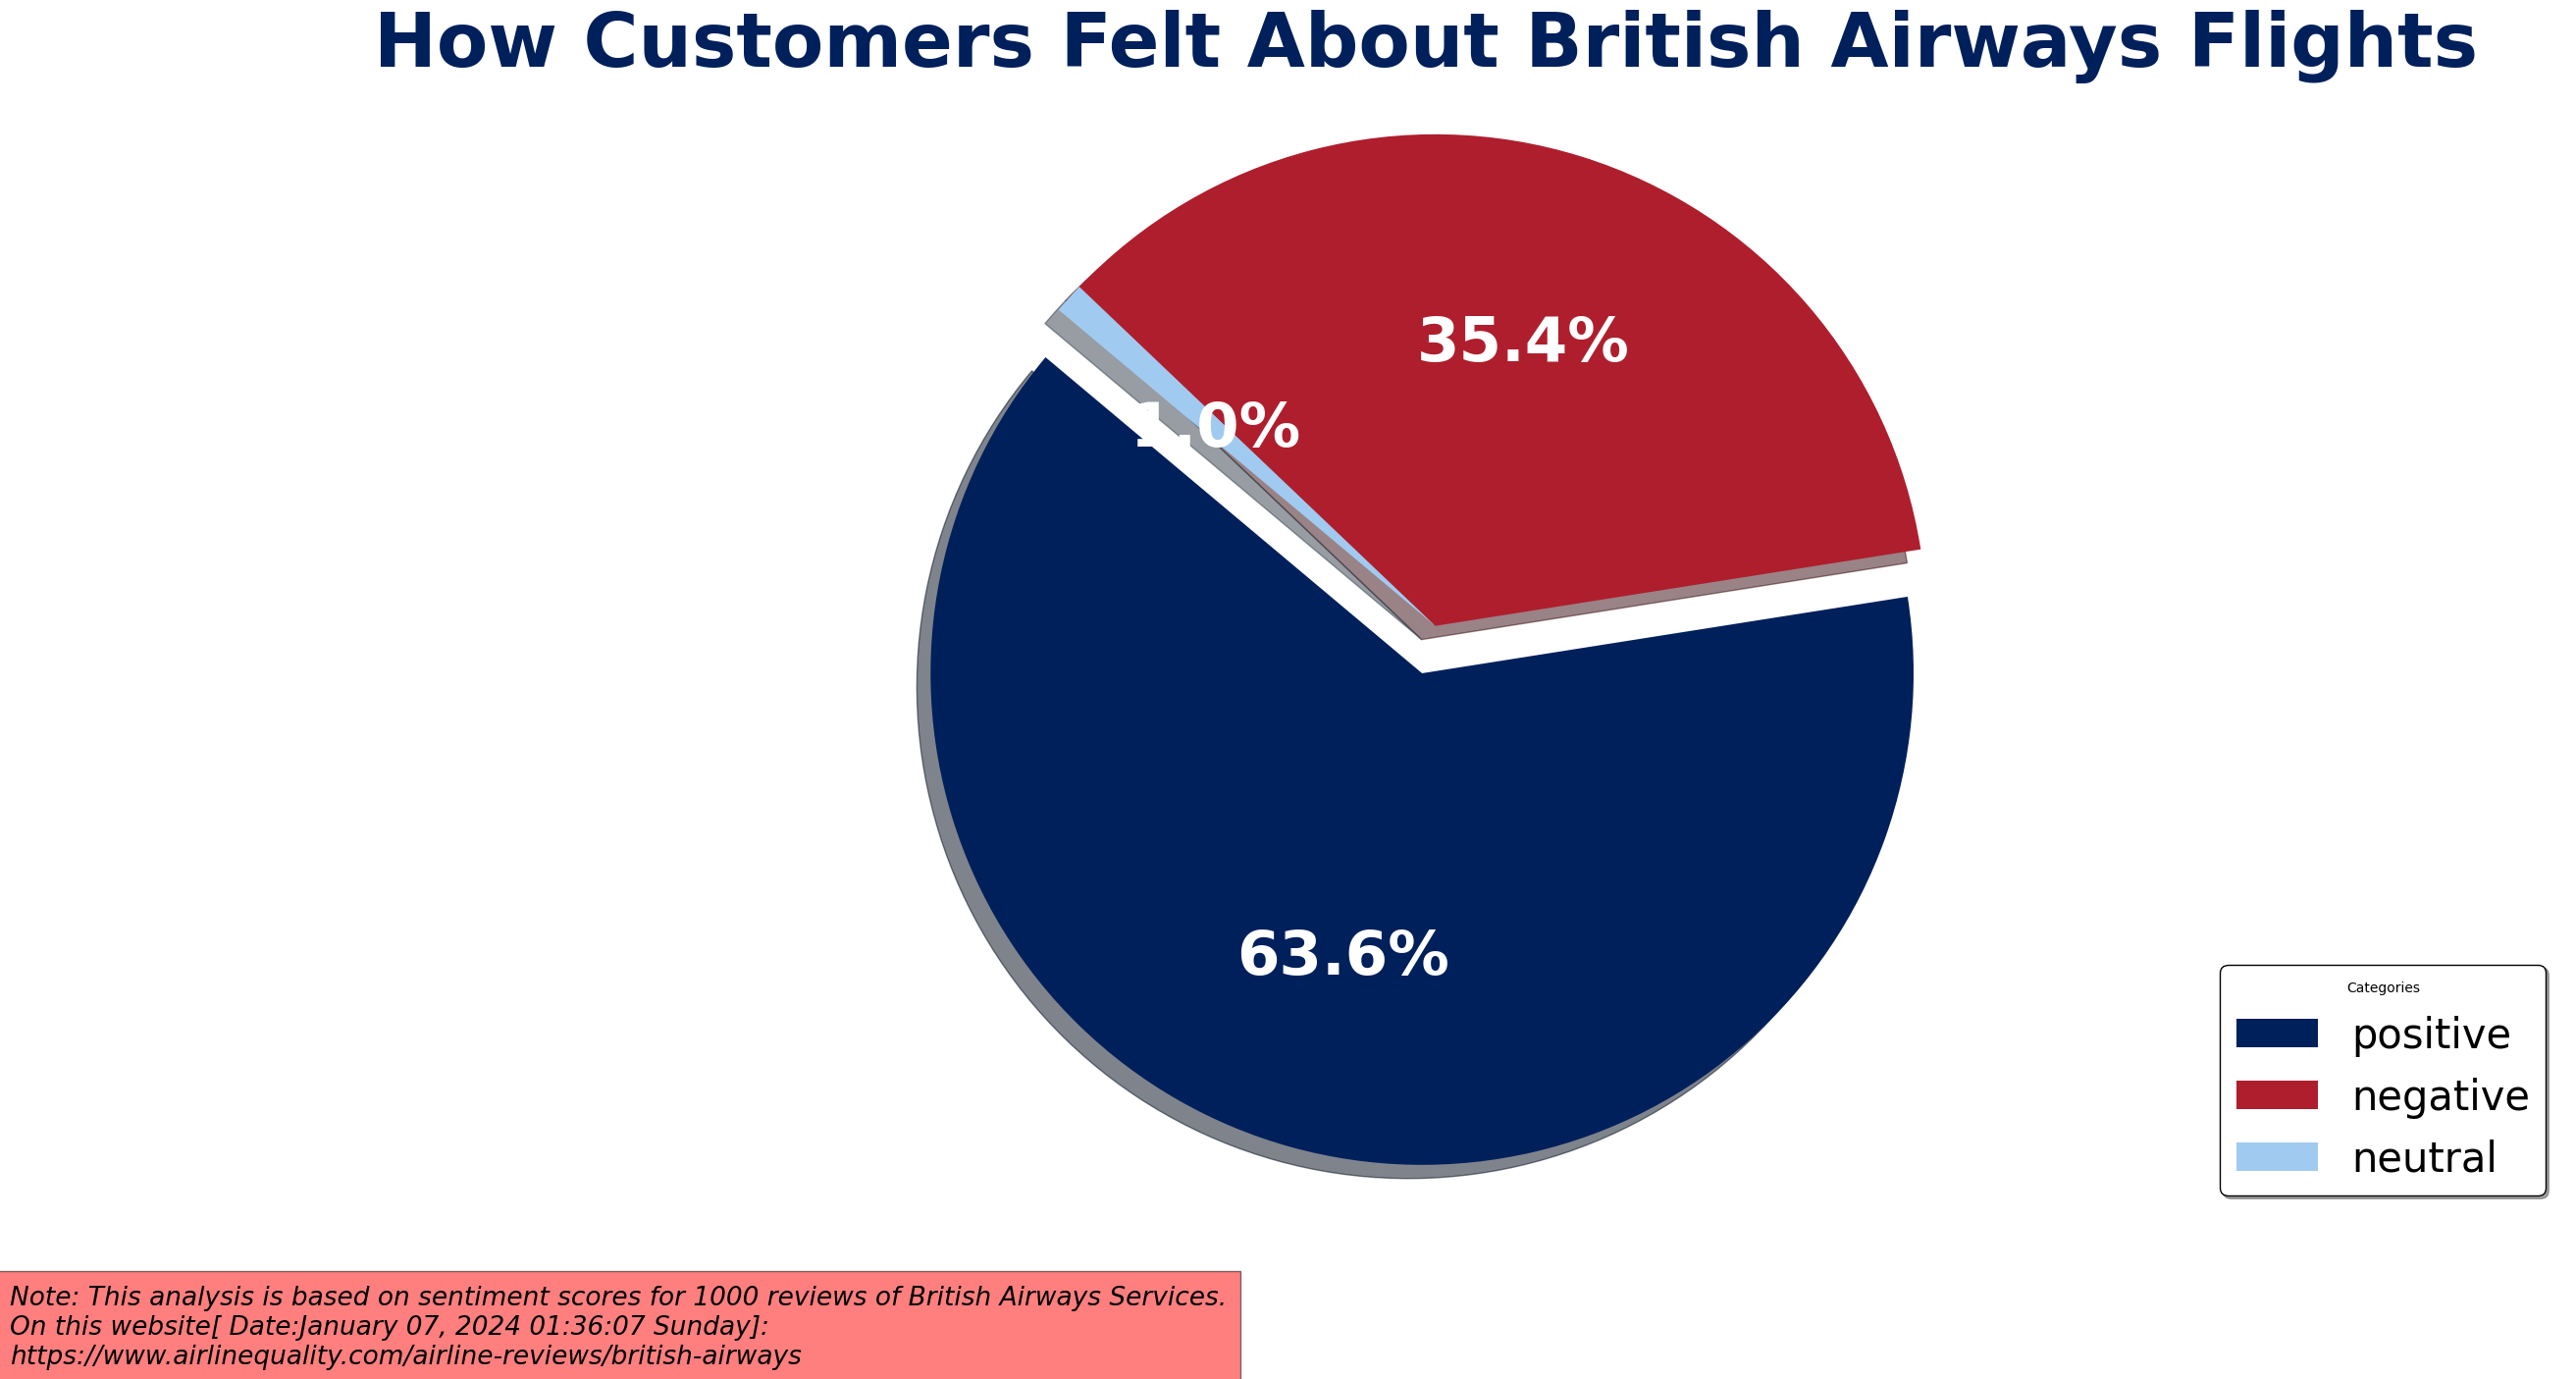

In [34]:
# import matplotlib 
import matplotlib.pyplot as plt
from datetime import datetime

# Assuming df is your DataFrame and 'sentiment_score' is your sentiment column
sentiment_counts = df['sentiment_score'].value_counts().reset_index()

# Rename the columns for better understanding
sentiment_counts.columns = ['sentiment', 'count']

colors = ['#00205b', '#af1e2d', '#a1caf1']  # British Airways brand colors
explode = (0.1, 0, 0)  # explode 1st slice

# Define a custom autopct function to make the percentage labels bolder
def custom_autopct(pct):
    return ('%1.1f%%' % pct) if pct > 0 else ''

# Plot
plt.pie(sentiment_counts['count'], 
        explode=explode, colors=colors,
        autopct=custom_autopct, 
        shadow=True, 
        startangle=140, 
        textprops={'fontsize': 45, 
                    'fontweight': 'bold',                                            
                    'fontfamily':'sans-serif', 
                    'color':'white'})

# make plot area big
fig = plt.gcf()
fig.set_size_inches(30,15)

plt.axis('equal')

# Add a title with a bolder font
plt.title('How Customers Felt About British Airways Flights', 
          fontdict={
                    'fontsize': 55, \
                    'fontweight': 'bold',\
                    'fontfamily':'sans-serif', 'color':'#00205b'})

# Add a legend
plt.legend(sentiment_counts['sentiment'],
           title="Categories", 
           loc="lower right",
           fontsize=30,
           shadow=True,  
           facecolor='white',  # Change background color
           edgecolor='black')  # Add an edge color
now = datetime.now()
# Format the date and time
formatted_now = now.strftime("%B %d, %Y %H:%M:%S %A")
side_note = (
    f'Note: This analysis is based on sentiment scores for 1000 reviews of '
    f'British Airways Services.\nOn this website[ Date:{formatted_now}]:\n'
    f'https://www.airlinequality.com/airline-reviews/british-airways'
)

# Format the date and time
formatted_now = now.strftime("%B %d, %Y %H:%M:%S %A")
# Add a side note
plt.text(-2.9, 
         -1.5, 
         side_note,
                    
        style='italic', 
        fontsize=19,
        bbox={'facecolor': 'red', 'alpha': 0.5, 'pad': 10,})

plt.show()


The pie chart shows that the majority of the reviews are positive. This is a good sign for British Airways as it shows that the majority of their customers are happy with their service.

<h3>Analysing the Topics Associated with each type of sentiment </h3>

I used the `wordcloud` package to visualise the sentiment of the reviews. Using `wordcloud` allowed me to visualise the top words based on the sentiment of the reviews (positive, negative, neutral).


In [16]:
from random import choice
from wordcloud import WordCloud
from datetime import datetime


# Get today's date and time for sidenote
now = datetime.now()

# Format the date and time
formatted_now = now.strftime("%B %d, %Y %H:%M:%S %A")


# shorten line of code
side_note = (
    f'Note: This analysis is based on sentiment scores for 1000 reviews of '
    f'British Airways Services.\nOn this website[ Date:{formatted_now}]:\n'
    f'https://www.airlinequality.com/airline-reviews/british-airways'
)
# Define the brand colors of British Airways
colors = ['#00205b', '#af1e2d', '#a1caf1']
# Define a custom color function
def custom_color_func(word, 
                     font_size,
                     position,
                     orientation, 
                     random_state=None, **kwargs):
    
    return choice(colors)


# retrieve reviews based on sentiment
positive_reviews = df[df['sentiment_score'] == 'positive']['cleaned_reviews']
negative_reviews = df[df['sentiment_score'] == 'negative']['cleaned_reviews']
neutral_reviews = df[df['sentiment_score'] == 'neutral']['cleaned_reviews']

# join all review sentimental words together
positive_words = ' '.join(positive_reviews)
negative_words = ' '.join(negative_reviews)
neutral_words = ' '.join(neutral_reviews)

# create wordclouds
positive_wordcloud = WordCloud(width=800, height=500, 
                                random_state=21, 
                                max_font_size=110, 
                                color_func=custom_color_func).generate(positive_words)
negative_wordcloud = WordCloud(width=800, height=500, 
                                random_state=21, 
                                max_font_size=110, 
                                color_func=custom_color_func).generate(negative_words)
neutral_wordcloud = WordCloud(width=800, height=500, 
                              random_state=21, 
                              max_font_size=110, 
                              color_func=custom_color_func).generate(neutral_words)


<h3> Positive Reviews</h3>

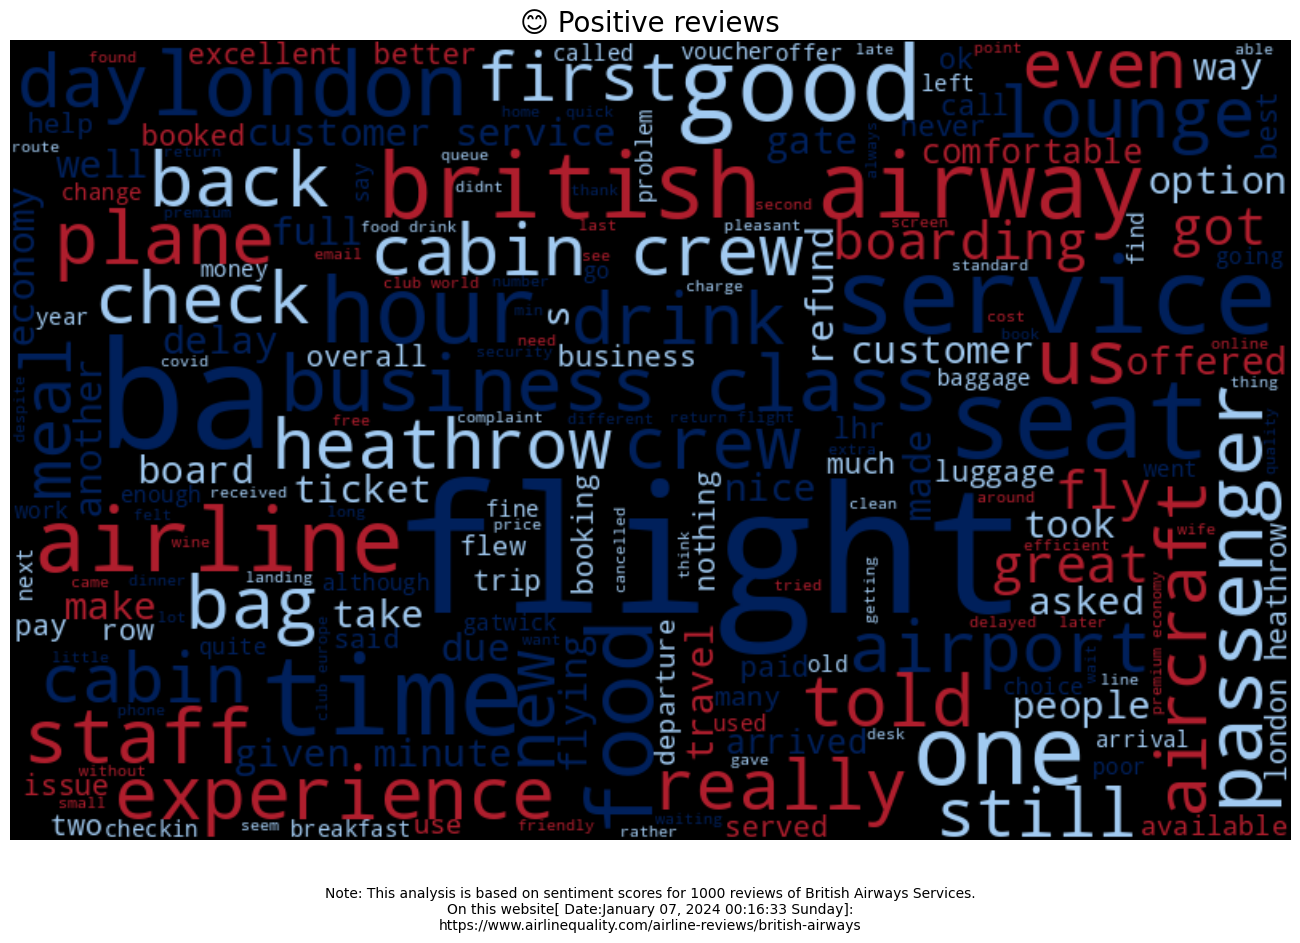

In [17]:

# plot wordclouds
fig, ax = plt.subplots(figsize=(20, 10))
plt.imshow(positive_wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title("😊 Positive reviews", fontdict={'fontsize': 20, 'fontweight': 'medium'})
plt.figtext(0.5, 0.01, side_note, fontsize=10, ha='center')
plt.subplots_adjust(left=0, right=1, top=0.9, bottom=0.1)
plt.show()


The wordcloud shows that the top words associated with positive reviews are "flight", "good", "experience", "Time", "food" 

<h3> Negative Reviews</h3>

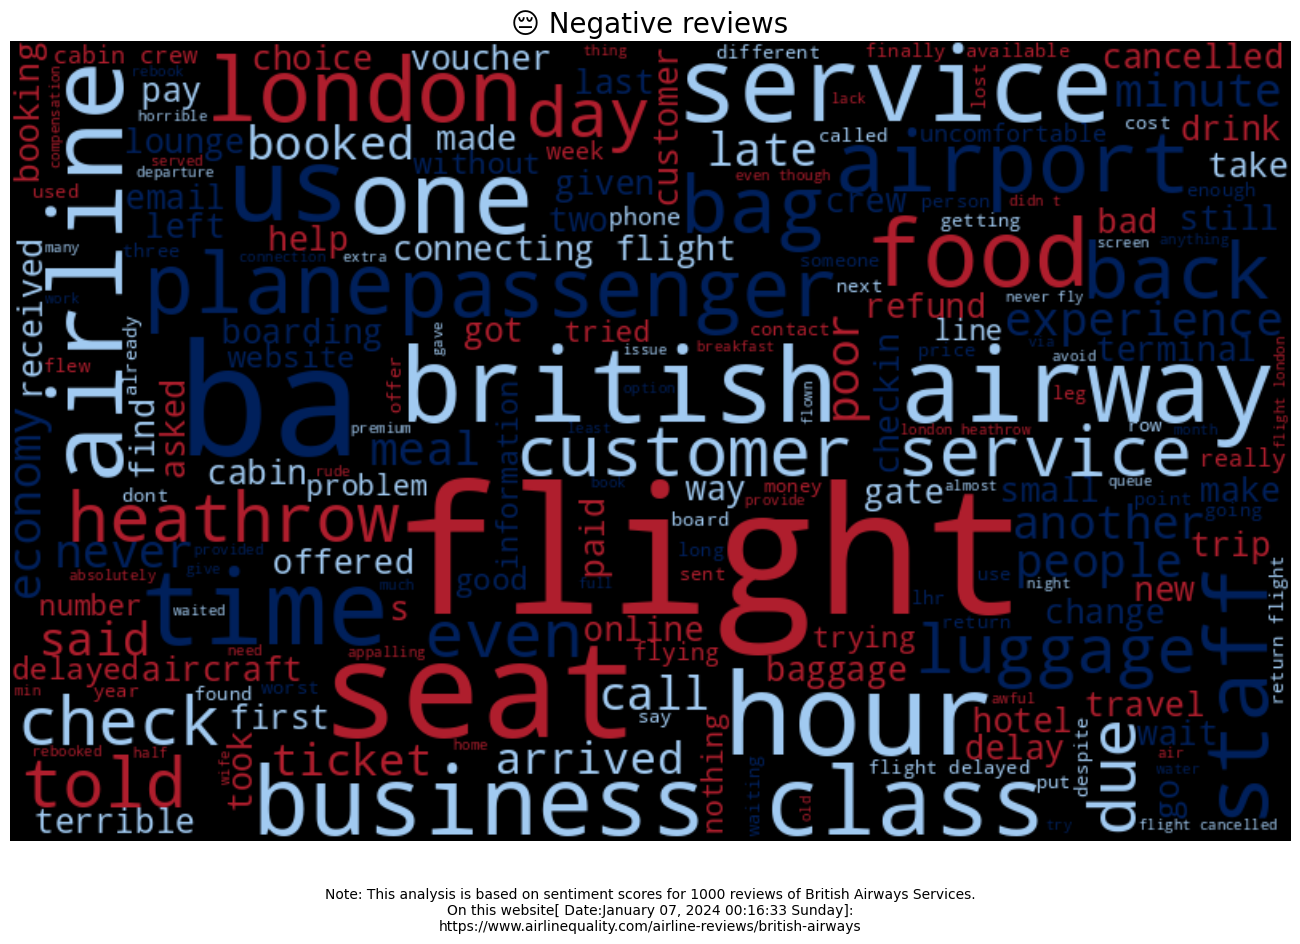

In [18]:

fig, ax = plt.subplots(figsize=(20, 10))
plt.imshow(negative_wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title("😔 Negative reviews", fontdict={'fontsize': 20, 'fontweight': 'medium'})
plt.figtext(0.5, 0.01, side_note, fontsize=10, ha='center')
plt.subplots_adjust(left=0, right=1, top=0.9, bottom=0.1)
plt.show()


The wordcloud shows that the top words associated with negative reviews are "flight", "service", "hour", "business class", "passenger", "food"

<h3> Neutral Reviews</h3>

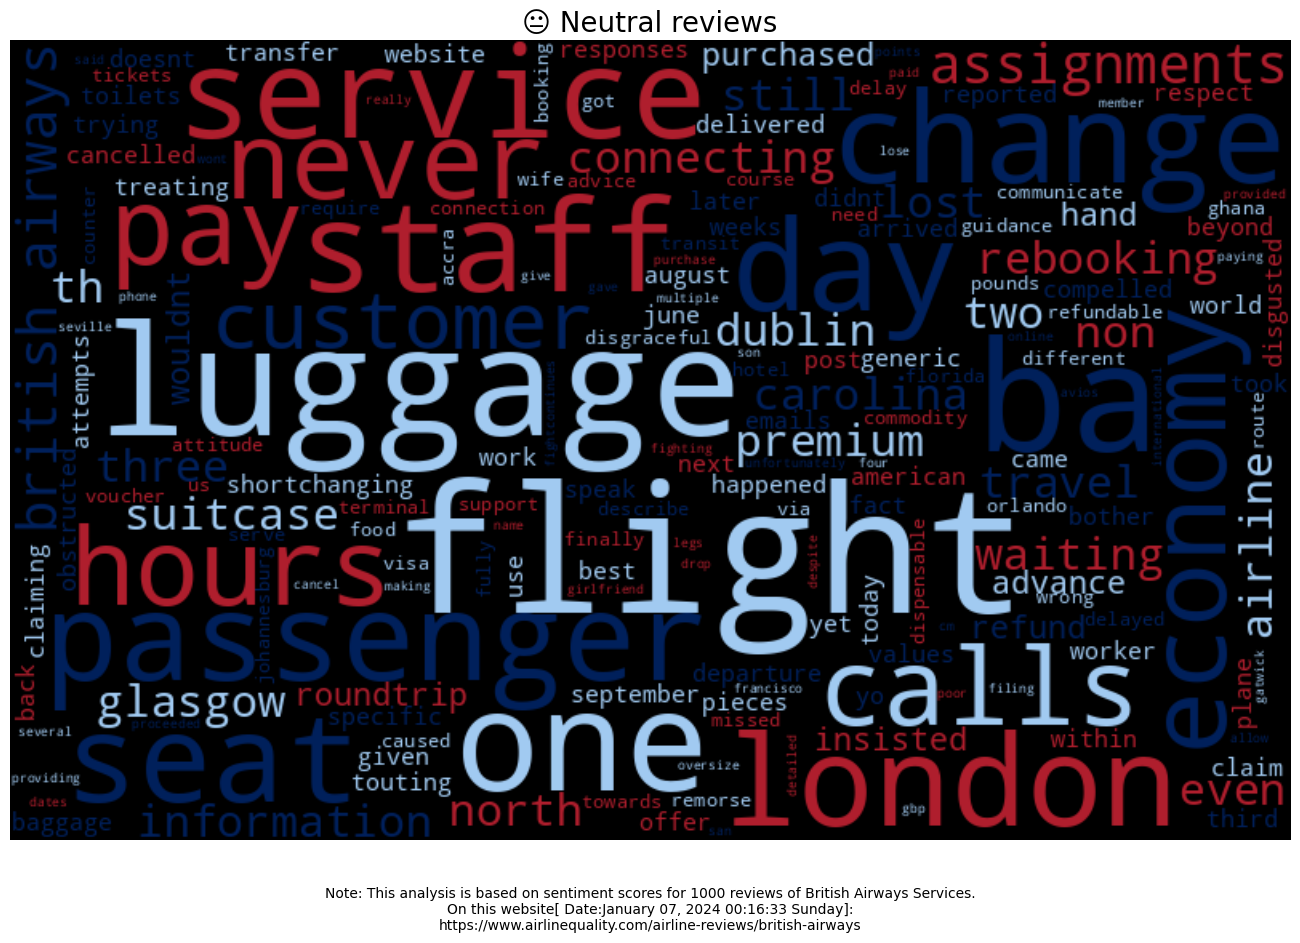

In [19]:

fig, ax = plt.subplots(figsize=(20, 10))
plt.imshow(neutral_wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title("😐 Neutral reviews", fontdict={'fontsize': 20, 'fontweight': 'medium'})
plt.figtext(0.5, 0.01, side_note, fontsize=10, ha='center')
plt.subplots_adjust(left=0, right=1, top=0.9, bottom=0.1)
plt.show()


The wordcloud shows that the top words associated with neutral reviews are "ok", "average", "fine", "okay", "reasonable", "standard", "fair", "normal", "satisfactory", "satisfied", "decent", "expected", "u

<h2>Conclusion</h2>
The analysis shows that the majority of the reviews are positive. 
<p>However, the analysis with negative sentiments suggests that British Airways should do further investigation into the following areas:</p>
<ul>
    <li>Flight services</li>
    <li>Food and drinks</li>
    <li>Flight crew</li>
    <li>Business class</li>
</ul>

<p>Further investigation into these areas will help British Airways to improve their services and increase customer satisfaction.</p>